## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Loading the Dataset

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
target='Survived'

In [3]:
data = pd.concat([train,test],axis=0)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data[['Name','SibSp','Parch']].isna().sum()

Name     0
SibSp    0
Parch    0
dtype: int64

In [6]:
data['Name_title']=data['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split('.')[0])
data['Family_size']=data['SibSp']+data['Parch']+1
data['Solo']=0
data.loc[data['Family_size']==1,'Solo']=1

The mean of the Target column is around 0.383 which means there exists class imbalance in the target variable which should be taken care of. The distribution of Survived and Not Survived population is 38% and 62% respectively.

In [7]:
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Family_size,Solo
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,1309,1309.000000,1309.000000
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3,18,NaN,NaN
top,NaN,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,Mr,NaN,NaN
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,757,NaN,NaN
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN,NaN,1.883881,0.603514
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN,NaN,1.583639,0.489354
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN,1.000000,0.000000
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,1.000000,1.000000
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,NaN,2.000000,1.000000


In [8]:
data.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
Name_title       18
Family_size       9
Solo              2
dtype: int64

Few numerical columns are having very few unique values and hence they can be categorical variables.
So we need to convert those columns into dummy variables.

In [9]:
# data= pd.get_dummies(data,columns=['Pclass','Sex','SibSp','Parch'])

In [10]:
data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Name_title        0
Family_size       0
Solo              0
dtype: int64

Columns with missing values are :
* Fare
* Age
* Cabin
* Embarked

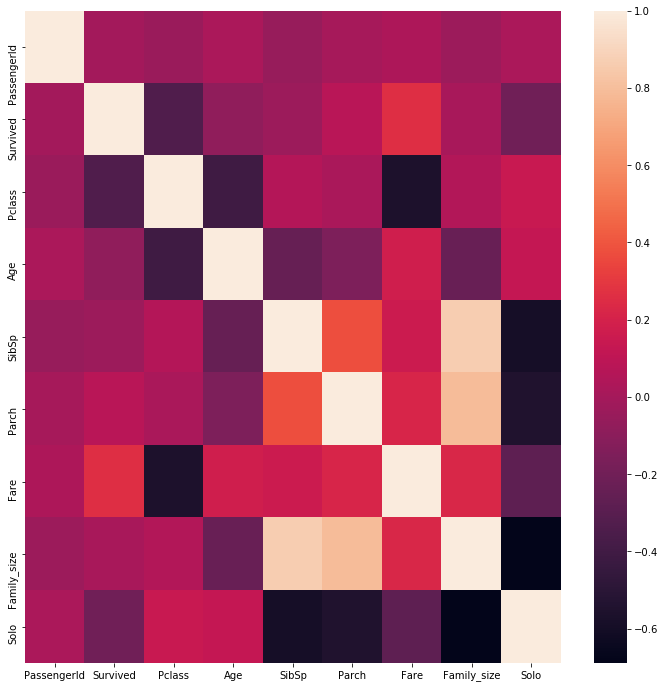

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr())

## Handling missing values.

### Embarked

In [12]:
data['Embarked'].isna().sum()

2

In [13]:
emb_train = data.loc[data['Embarked'].notna(),['Pclass','Fare','Parch','SibSp','Embarked']]
emb_missed= data.loc[data['Embarked'].isna(),['Pclass','Fare','Parch','SibSp']]
emb_train=emb_train.dropna()
emb_train=pd.get_dummies(emb_train,columns=['Pclass','Parch','SibSp'])
emb_missed=pd.get_dummies(emb_missed,columns=['Pclass','Parch','SibSp'])

In [14]:
emb_x=emb_train.columns[emb_train.columns != 'Embarked'].tolist()
emb_y='Embarked'
emb_train1, emb_val, train1_embarked,val_embarked = train_test_split(emb_train[emb_x],emb_train[emb_y],stratify=emb_train[emb_y], test_size=0.15, random_state=122)

In [15]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 3).fit(emb_train1, train1_embarked)
print('Accuracy: {:.0f}%'.format(knn.score(emb_val,val_embarked)*100))
del(emb_train1, emb_val, train1_embarked,val_embarked)

Accuracy: 86%


Using K-Nearest Neighbours classifier with *n_neighbors = 3* we got a validation accuracy of ~86%. Using this we will impute the missing Embarked values.

In [16]:
emb_model = KNeighborsClassifier(n_neighbors=3)
emb_model.fit(emb_train[emb_x],emb_train[emb_y])
data_emb=data.copy()
data_emb=pd.get_dummies(data_emb,columns=['Pclass','Parch','SibSp'])
data.loc[data['Embarked'].isna(),'Embarked']=emb_model.predict(data_emb.loc[data_emb['Embarked'].isna(),emb_x])
del(data_emb,emb_x,emb_y)

In [17]:
data['Embarked'].isna().sum()

0

### Fare

The fare should be dependent on the Passenger Class and Embarkment location mainly.
So testing this hypothesis

In [18]:
data['Fare'].isna().sum()

1

**Mapping the Fare values of Test data to the closest Fare values for the train data.**

In [19]:
#Function to get the closest value from the dataset for the passed value
def get_closest(data,value):
    a=data.unique().tolist()
    min_idx=min(range(len(a)),key=lambda i: abs(a[i]-value))
    return a[min_idx]

In [20]:
data[data[target].isna()]['Fare']=data[data[target].isna()]['Fare'].apply(lambda x: get_closest(data[data[target].notna()]['Fare'],x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
data.groupby(['Embarked','Pclass'])['Fare'].mean()

Embarked  Pclass
C         1         106.469871
          2          23.300593
          3          11.021624
Q         1          90.000000
          2          11.735114
          3          10.390820
S         1          72.148094
          2          21.206921
          3          14.435422
Name: Fare, dtype: float64

It can seen that the fares for different embarkment location has a decreasing mean with the downgradation of Passenger Class.

In [22]:
#Getting the Pclass and Embarked of the missing value of Fare
data.loc[data['Fare'].isna(),['Pclass','Embarked']]

,Pclass,Embarked
152,3,S


In [23]:
#Since the mean of Pclass=3 and Embarked=S is 14.44
Fare=data.loc[(data[target].isna())&(data['Pclass']==3)&(data['Embarked']=='S'),'Fare'].unique().tolist()
data.loc[data['Fare'].isna(),'Fare']=Fare[min(range(len(Fare)),key=lambda i: abs(Fare[i]-14.435422))]

In [24]:
data['Fare'].isna().sum()

0

### Age

In [25]:
data['Age'].isna().sum()

263

In [26]:
data.loc[data['Age'].notna(),'Name_title'].value_counts()

 Mr              581
 Miss            210
 Mrs             170
 Master           53
 Rev               8
 Dr                7
 Col               4
 Major             2
 Mlle              2
 Jonkheer          1
 Capt              1
 Lady              1
 the Countess      1
 Dona              1
 Ms                1
 Mme               1
 Don               1
 Sir               1
Name: Name_title, dtype: int64

In [27]:
data.loc[data['Age'].isna(),'Name_title'].value_counts()

 Mr        176
 Miss       50
 Mrs        27
 Master      8
 Ms          1
 Dr          1
Name: Name_title, dtype: int64

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
age_df=data[data['Age'].notna()][['Name_title','Solo','Age']]
age_df=pd.get_dummies(age_df,columns=['Name_title'],drop_first=True)
age_feat=age_df.columns[age_df.columns != 'Age'].tolist()
age_train,age_val,age_train_lbl,age_val_lbl=train_test_split(age_df[age_feat],age_df['Age'], test_size = 0.3,random_state=10)
    
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':range(1,20)}

knn = KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=25)
model.fit(age_train,age_train_lbl)
print(model.best_params_)

del(age_train,age_val,age_train_lbl,age_val_lbl,model)

{'n_neighbors': 18}


The least error is obtained using K = 18

In [29]:
age_model = KNeighborsRegressor(n_neighbors=18)
age_model.fit(age_df[age_feat],age_df['Age'])
data_age=data.copy()
data_age=pd.get_dummies(data_age,columns=['Name_title'])
data.loc[data['Age'].isna(),'Age']=age_model.predict(data_age.loc[data_age['Age'].isna(),age_feat])
del(age_df,data_age,age_feat,age_model)

In [30]:
data['Age'].isna().sum()

0

### Preprocessing
* Drop columns **PassengerId**,**Cabin**,**Name** and **Ticket**.
* Divide columns **Age** and **Fare** into bins.

In [31]:
data['Age_bins']=pd.qcut(data['Age'],5)
data['Fare_bins']=pd.qcut(data['Fare'],4)

In [32]:
data=data.drop(['PassengerId','Cabin','Name','SibSp','Parch','Ticket','Age','Fare'],axis=1)

In [33]:
data['Sex'] = data['Sex'].map({'male':0,'female':1})
data.head()

,Survived,Pclass,Sex,Embarked,Name_title,Family_size,Solo,Age_bins,Fare_bins
0,0.0,3,0,S,Mr,2,0,"(20.0, 27.0]","(-0.001, 7.896]"
1,1.0,1,1,C,Mrs,2,0,"(34.0, 39.0]","(31.275, 512.329]"
2,1.0,3,1,S,Miss,1,1,"(20.0, 27.0]","(7.896, 14.454]"
3,1.0,1,1,S,Mrs,2,0,"(34.0, 39.0]","(31.275, 512.329]"
4,0.0,3,0,S,Mr,1,1,"(34.0, 39.0]","(7.896, 14.454]"


In [34]:
data=pd.get_dummies(data,columns=['Pclass','Name_title','Embarked','Age_bins','Fare_bins'],drop_first=True)
features=data.columns.tolist()
features.remove(target)
data_train=data.loc[data[target].notna()]
data_test=data.loc[data[target].isna()]

In [35]:
x_train=data_train[features]
y_train=data_train[target].astype(int)
x_test=data_test[features]

In [36]:
y_train = np.array(y_train)

In [37]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(x_train)
x_scaled_train=scaler.transform(x_train)
x_scaled_train

array([[-0.73769513,  0.05915988, -1.2316449 , ..., -0.57951021,
        -0.58815087, -0.56395686],
       [ 1.35557354,  0.05915988, -1.2316449 , ..., -0.57951021,
        -0.58815087,  1.77318528],
       [ 1.35557354, -0.56097483,  0.81192233, ...,  1.72559514,
        -0.58815087, -0.56395686],
       ...,
       [ 1.35557354,  1.29942929, -1.2316449 , ..., -0.57951021,
         1.70024401, -0.56395686],
       [-0.73769513, -0.56097483,  0.81192233, ..., -0.57951021,
         1.70024401, -0.56395686],
       [-0.73769513, -0.56097483,  0.81192233, ..., -0.57951021,
        -0.58815087, -0.56395686]])

In [38]:
x_scaled_test=scaler.transform(x_test)
x_scaled_test

array([[-0.73769513, -0.56097483,  0.81192233, ..., -0.57951021,
        -0.58815087, -0.56395686],
       [ 1.35557354,  0.05915988, -1.2316449 , ..., -0.57951021,
        -0.58815087, -0.56395686],
       [-0.73769513, -0.56097483,  0.81192233, ...,  1.72559514,
        -0.58815087, -0.56395686],
       ...,
       [-0.73769513, -0.56097483,  0.81192233, ..., -0.57951021,
        -0.58815087, -0.56395686],
       [-0.73769513, -0.56097483,  0.81192233, ...,  1.72559514,
        -0.58815087, -0.56395686],
       [-0.73769513,  0.67929458, -1.2316449 , ..., -0.57951021,
         1.70024401, -0.56395686]])

## PARAMETER TUNING

In [39]:
param_test1 = {'max_depth':range(1,10),
               'min_child_weight':range(1,6)
              }
gsearch1 = GridSearchCV(
    estimator = XGBClassifier(learning_rate =0.05,
                              n_estimators=500,
                              max_depth=5,
                              min_child_weight=1,
                              gamma=0,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              objective= 'binary:logistic',
                              nthread=4,
                              scale_pos_weight=1,
                              seed=27),
    param_grid = param_test1,
    scoring='roc_auc',
    n_jobs=4,
    cv=5)
gsearch1.fit(x_scaled_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 2, 'min_child_weight': 2}, 0.8789991926349536)

In [40]:
param_test2 = {'gamma':[i/10.0 for i in range(0,5)]
              }
gsearch2 = GridSearchCV(
    estimator = XGBClassifier(learning_rate =0.05,
                              n_estimators=500,
                              max_depth=2,
                              min_child_weight=2,
                              gamma=0,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              objective= 'binary:logistic',
                              nthread=4,
                              scale_pos_weight=1,
                              seed=27),
    param_grid = param_test2,
    scoring='roc_auc',
    n_jobs=4,
    cv=5)
gsearch2.fit(x_scaled_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.0}, 0.8789991926349536)

In [41]:
param_test3 = {'subsample':[i/100.0 for i in range(75,90,5)],
               'colsample_bytree':[i/100.0 for i in range(75,90,5)]
              }

gsearch3 = GridSearchCV(
    estimator = XGBClassifier(learning_rate =0.05,
                              n_estimators=500,
                              max_depth=2,
                              min_child_weight=2,
                              gamma=0,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              objective= 'binary:logistic',
                              nthread=4,
                              scale_pos_weight=1,
                              seed=27),
    param_grid = param_test3,
    scoring='roc_auc',
    n_jobs=4,
    cv=5)
gsearch3.fit(x_scaled_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8789991926349536)

In [42]:
param_test4 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

gsearch4 = GridSearchCV(
    estimator = XGBClassifier(learning_rate =0.05,
                              n_estimators=500,
                              max_depth=2,
                              min_child_weight=2,
                              gamma=0,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              objective= 'binary:logistic',
                              nthread=4,
                              scale_pos_weight=1,
                              seed=27),
    param_grid = param_test4,
    scoring='roc_auc',
    n_jobs=4,
    cv=5)
gsearch4.fit(x_scaled_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

({'reg_alpha': 1e-05}, 0.8789991926349536)

In [43]:
predictor=XGBClassifier(learning_rate =0.05,
                          n_estimators=500,
                          max_depth=2,
                          min_child_weight=2,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          reg_alpha=1e-5,
                          scale_pos_weight=1,
                          seed=27)
predictor.fit(x_scaled_train,y_train)
submission=pd.DataFrame(columns=['PassengerId',target])
submission['PassengerId']=test['PassengerId']
submission[target]=predictor.predict(x_scaled_test)
submission[target]=submission[target].apply(lambda x: int(x))
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [44]:
submission.to_csv('xgb.csv',index=False)